In [ ]:
!pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.9 MB/s eta 0:00:00


In [ ]:
#Geração da base de dados simulada

import pandas as pd
import random
from faker import Faker

# Inicializando Faker
fake = Faker()

# Configurando parâmetros
num_orders = 1000  # Quantidade de pedidos
num_products = 50  # Quantidade de produtos
max_items_per_order = 10  # Máximo de itens por pedido

# Listas de produtos reais por categoria
products_by_category = {
    "Bebidas": ["Coca-Cola", "Água Mineral", "Suco de Laranja", "Cerveja", "Vinho Tinto"],
    "Higiene": ["Shampoo", "Sabonete", "Pasta de Dente", "Desodorante", "Papel Higiênico"],
    "Alimentos": ["Arroz", "Feijão", "Macarrão", "Carne Moída", "Leite"],
    "Limpeza": ["Sabão em Pó", "Detergente", "Esponja", "Água Sanitária", "Multiuso"],
    "Eletrônicos": ["Fone de Ouvido", "Carregador USB", "Pilha", "Lâmpada LED", "Bateria"]
}

# Criando a tabela de Produtos
products = []
product_id = 1

for category, product_list in products_by_category.items():
    for product_name in product_list:
        products.append({
            'product_id': product_id,
            'product_name': product_name,
            'category': category,
            'price': round(random.uniform(1, 100), 2)
        })
        product_id += 1

products_df = pd.DataFrame(products)

# Criando a tabela de Pedidos
orders = []

for order_id in range(1, num_orders + 1):
    orders.append({
        'order_id': order_id,
        'customer_id': random.randint(1, 300),
        'order_date': fake.date_between(start_date="-1y", end_date="today"),
        'total_value': 0  # Será ajustado posteriormente
    })

orders_df = pd.DataFrame(orders)

# Criando a tabela de Itens do Pedido
order_items = []

for order in orders:
    num_items = random.randint(1, max_items_per_order)
    items_in_order = random.sample(range(1, len(products) + 1), num_items)

    for product_id in items_in_order:
        quantity = random.randint(1, 5)
        product_price = products_df.loc[products_df['product_id'] == product_id, 'price'].values[0]
        total_item_price = round(product_price * quantity, 2)

        order_items.append({
            'order_id': order['order_id'],
            'product_id': product_id,
            'quantity': quantity,
            'item_total': total_item_price
        })

# Atualizando o valor total dos pedidos na tabela de Pedidos
order_items_df = pd.DataFrame(order_items)

total_values = order_items_df.groupby('order_id')['item_total'].sum().reset_index()
total_values.rename(columns={'item_total': 'total_value'}, inplace=True)

orders_df = orders_df.merge(total_values, on='order_id')

# Salvando os datasets em CSV
products_df.to_csv('products.csv', index=False)
orders_df.to_csv('orders.csv', index=False)
order_items_df.to_csv('order_items.csv', index=False)

print("Datasets criados e salvos:")
print("- products.csv")
print("- orders.csv")
print("- order_items.csv")



Datasets criados e salvos:
- products.csv
- orders.csv
- order_items.csv


In [1]:
# Desinstalar qualquer instalação antiga do PySpark
!pip uninstall -y pyspark

# Remover diretórios antigos do Apache Spark
!rm -rf /content/spark-*
!rm -rf /usr/local/lib/python3.*/dist-packages/pyspark
!rm -rf /usr/local/lib/python3.*/site-packages/pyspark
!rm -rf /content/spark-3.0.0-bin-hadoop2.7


Found existing installation: pyspark 3.5.4
Uninstalling pyspark-3.5.4:
  Successfully uninstalled pyspark-3.5.4


In [2]:
#instalando Java Runtime Environment (JRE) versão 8
%%capture
!apt-get remove openjdk*
!apt-get update --fix-missing
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [3]:
import os
# Configurando as variáveis de ambiente corretamente
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [4]:
%%capture
#instalando o pacote pyspark
!pip install pyspark==3.3.2

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("pyspark-colab").master("local[*]").getOrCreate()

# Pedidos (orders): Contém informações sobre cada pedido, incluindo datas e identificadores de cliente e pedido.
# Itens de Pedido (order_items): Apresenta detalhes de cada item adquirido, como o ID do produto e o ID do pedido ao qual está associado.
# Produtos (products): Inclui dados sobre os produtos, como categoria, descrição e identificador.
# Pagamentos (order_payments): Oferece dados financeiros, incluindo valores de pagamento, método de pagamento e quantidade de parcelas.

#criando os DataFrames em Spark
orders = spark.read.csv(path="orders.csv", header=True, sep=",")
order_items = spark.read.csv(path="order_items.csv", header=True, sep=",")
products = spark.read.csv(path="products.csv", header=True, sep=",")

# importando funções adicionais
from pyspark.sql.functions import round, desc

#criando as visões temporárias
orders.createOrReplaceTempView("orders")
order_items.createOrReplaceTempView("order_items")
products.createOrReplaceTempView("products")

Estatísticas Descritivas:
             price     quantity   item_total  total_value_y
count  5366.000000  5366.000000  5366.000000    5366.000000
mean     44.949020     3.044726   136.849944     931.327887
std      29.838244     1.420346   118.660808     434.627900
min       1.600000     1.000000     1.600000       3.200000
25%      13.850000     2.000000    41.550000     624.500000
50%      48.440000     3.000000    96.880000     910.240000
75%      68.970000     4.000000   206.910000    1206.220000
max      96.190000     5.000000   480.950000    2480.920000


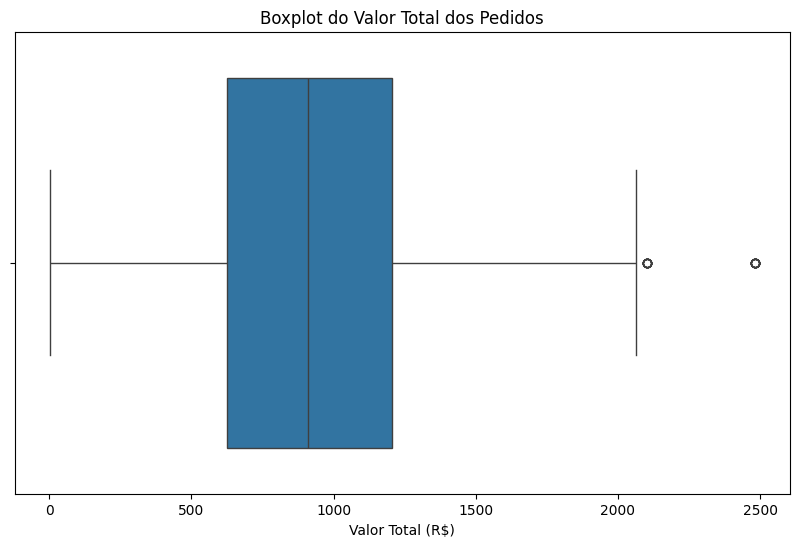

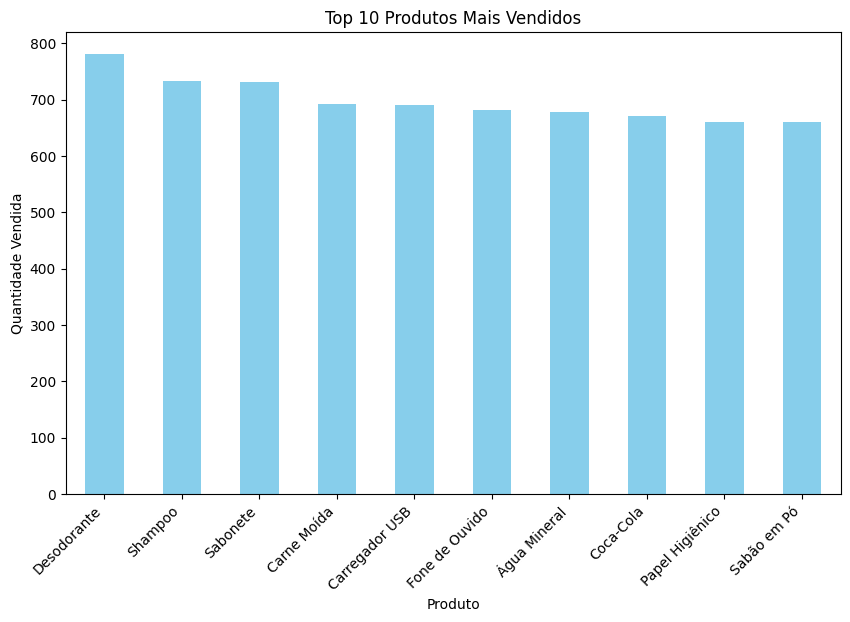

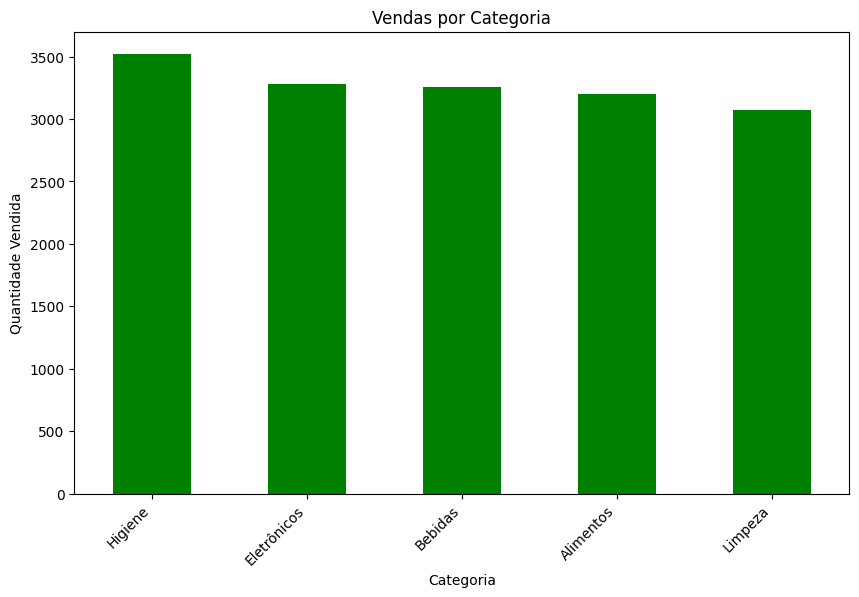

In [6]:
#análise exploratória

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar os dados das tabelas fornecidas
# Substituir 'order_items.csv', 'orders.csv', 'products.csv' pelos arquivos relevantes
orders = pd.read_csv("orders.csv")
order_items = pd.read_csv("order_items.csv")
products = pd.read_csv("products.csv")

# Merge das tabelas
merged_data = pd.merge(order_items, products, on="product_id")
merged_data = pd.merge(merged_data, orders, on="order_id")

# Estatísticas Descritivas
print("Estatísticas Descritivas:")
print(merged_data[['price', 'quantity', 'item_total', 'total_value_y']].describe())

# Boxplot para Detecção de Outliers no Valor Total dos Pedidos
plt.figure(figsize=(10, 6))
sns.boxplot(x=merged_data['total_value_y'])
plt.title("Boxplot do Valor Total dos Pedidos")
plt.xlabel("Valor Total (R$)")
plt.show()

# Gráfico de Barras para Produtos Mais Vendidos
top_products = merged_data.groupby('product_name')['quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
top_products.plot(kind='bar', color='skyblue')
plt.title("Top 10 Produtos Mais Vendidos")
plt.ylabel("Quantidade Vendida")
plt.xlabel("Produto")
plt.xticks(rotation=45, ha='right')
plt.show()

# Gráfico de Barras para Categorias Mais Vendidas
category_sales = merged_data.groupby('category')['quantity'].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
category_sales.plot(kind='bar', color='green')
plt.title("Vendas por Categoria")
plt.ylabel("Quantidade Vendida")
plt.xlabel("Categoria")
plt.xticks(rotation=45, ha='right')
plt.show()



In [7]:
spark.sql("""
-- Filtra os pedidos e associa os produtos comprados
CREATE OR REPLACE TEMP VIEW transactions AS
SELECT
    o.order_id,
    p.product_name
FROM
    order_items o
JOIN
    products p
ON
    o.product_id = p.product_id;
""").show();

spark.sql("""
CREATE OR REPLACE TEMP VIEW transactional_format AS
SELECT
    order_id,
    COLLECT_LIST(product_name) AS products
FROM
    transactions
GROUP BY
    order_id;
""").show();

spark.sql("""
-- Consulta final para visualizar os dados no formato transacional
SELECT *
FROM transactional_format;
""").show(100, truncate=False);


transactional_format = spark.sql("""
-- Consulta final para visualizar os dados no formato transacional
SELECT *
FROM transactional_format;
""")

++
||
++
++

++
||
++
++

+--------+--------------------------------------------------------------------------------------------------------------------------------+
|order_id|products                                                                                                                        |
+--------+--------------------------------------------------------------------------------------------------------------------------------+
|1       |[Feijão, Shampoo]                                                                                                               |
|10      |[Leite]                                                                                                                         |
|100     |[Bateria, Desodorante, Água Sanitária, Fone de Ouvido, Lâmpada LED, Pasta de Dente, Macarrão, Shampoo]                          |
|1000    |[Fone de Ouvido, Bateria, Leite]                                                                                            

In [8]:
import mlxtend
print(mlxtend.__version__)

0.23.4


In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# 1. Carregar os dados do Spark para Pandas
transactional_df = spark.sql("SELECT * FROM transactional_format")
transactional_pandas = transactional_df.toPandas()

# 2. Remover duplicatas em cada transação (eliminação de redundâncias)
transactional_pandas['products'] = transactional_pandas['products'].apply(lambda x: list(set(x)))

# 3. Verifique o formato das categorias
print(transactional_pandas.head(10))

/usr/local/lib/python3.11/dist-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
/usr/local/lib/python3.11/dist-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):


  order_id                                           products
0        1                                  [Shampoo, Feijão]
1       10                                            [Leite]
2      100  [Pasta de Dente, Desodorante, Bateria, Fone de...
3     1000                   [Leite, Fone de Ouvido, Bateria]
4      101  [Bateria, Desodorante, Papel Higiênico, Água S...
5      102  [Multiuso, Esponja, Feijão, Arroz, Suco de Lar...
6      103              [Lâmpada LED, Água Mineral, Multiuso]
7      104  [Sabão em Pó, Água Mineral, Bateria, Fone de O...
8      105  [Água Mineral, Papel Higiênico, Feijão, Água S...
9      106  [Água Mineral, Desodorante, Sabonete, Feijão, ...


In [10]:
# One-Hot Encoding das categorias
te = TransactionEncoder()
te_ary = te.fit(transactional_pandas['products']).transform(transactional_pandas['products'])
transaction_df = pd.DataFrame(te_ary, columns=te.columns_)

# Visualizar a matriz binária
print(transaction_df.head())

   Arroz  Bateria  Carne Moída  Carregador USB  Cerveja  Coca-Cola  \
0  False    False        False           False    False      False   
1  False    False        False           False    False      False   
2  False     True        False           False    False      False   
3  False     True        False           False    False      False   
4  False     True        False           False     True      False   

   Desodorante  Detergente  Esponja  Feijão  ...  Papel Higiênico  \
0        False       False    False    True  ...            False   
1        False       False    False   False  ...            False   
2         True       False    False   False  ...            False   
3        False       False    False   False  ...            False   
4         True       False    False   False  ...             True   

   Pasta de Dente  Pilha  Sabonete  Sabão em Pó  Shampoo  Suco de Laranja  \
0           False  False     False        False     True            False   
1         

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
# Apriori com suporte mínimo ajustado
frequent_itemsets = apriori(transaction_df, min_support=0.01, use_colnames=True)

# Verificar os itemsets frequentes
if frequent_itemsets.empty:
    print("Nenhum item frequente encontrado. Considere reduzir o min_support.")
else:
    print("Itens frequentes encontrados:")
    print(frequent_itemsets)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Itens frequentes encontrados:
      support                                           itemsets
0       0.219                                            (Arroz)
1       0.205                                          (Bateria)
2       0.229                                      (Carne Moída)
3       0.222                                   (Carregador USB)
4       0.211                                          (Cerveja)
...       ...                                                ...
2296    0.011              (Leite, Sabão em Pó, Pilha, Sabonete)
2297    0.011  (Lâmpada LED, Papel Higiênico, Pasta de Dente,...
2298    0.010      (Vinho Tinto, Lâmpada LED, Sabonete, Shampoo)
2299    0.012            (Sabão em Pó, Pilha, Sabonete, Shampoo)
2300    0.010       (Sabão em Pó, Pilha, Sabonete, Água Mineral)

[2301 rows x 2 columns]


In [14]:
# Gerar regras de associação com métricas ajustadas
num_itemsets = len(frequent_itemsets)  # Calcular o número total de itemsets
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5, num_itemsets=num_itemsets)

# Verificar as regras encontradas
if rules.empty:
    print("\nNenhuma regra de associação encontrada. Considere ajustar os parâmetros.")
else:
    print("\nRegras de associação encontradas:")
    print(rules)


Regras de associação encontradas:
                                antecedents        consequents  \
0                      (Sabão em Pó, Pilha)         (Sabonete)   
1           (Arroz, Pilha, Papel Higiênico)      (Carne Moída)   
2               (Arroz, Pilha, Carne Moída)  (Papel Higiênico)   
3     (Arroz, Papel Higiênico, Carne Moída)            (Pilha)   
4   (Carregador USB, Arroz, Pasta de Dente)  (Papel Higiênico)   
..                                      ...                ...   
74         (Sabão em Pó, Sabonete, Shampoo)            (Pilha)   
75               (Pilha, Sabonete, Shampoo)      (Sabão em Pó)   
76       (Sabão em Pó, Pilha, Água Mineral)         (Sabonete)   
77    (Sabão em Pó, Sabonete, Água Mineral)            (Pilha)   
78          (Água Mineral, Pilha, Sabonete)      (Sabão em Pó)   

    antecedent support  consequent support  support  confidence      lift  \
0                0.057               0.243    0.029    0.508772  2.093712   
1                0

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
# Filtrar regras com lift > 1.0 e confiança > 0.5 and suporte >= 1.0
rules_filtered = rules[(rules['lift'] > 1.0) & (rules['confidence'] > 0.5) & (rules['support'] >= 0.01)]

print("\nRegras filtradas:")
print(len(rules_filtered))

print(rules_filtered.head())


Regras filtradas:
64
                               antecedents        consequents  \
0                     (Sabão em Pó, Pilha)         (Sabonete)   
2              (Arroz, Pilha, Carne Moída)  (Papel Higiênico)   
3    (Arroz, Papel Higiênico, Carne Moída)            (Pilha)   
4  (Carregador USB, Arroz, Pasta de Dente)  (Papel Higiênico)   
7           (Carregador USB, Arroz, Pilha)         (Sabonete)   

   antecedent support  consequent support  support  confidence      lift  \
0               0.057               0.243    0.029    0.508772  2.093712   
2               0.012               0.218    0.010    0.833333  3.822630   
3               0.018               0.213    0.010    0.555556  2.608242   
4               0.015               0.218    0.010    0.666667  3.058104   
7               0.017               0.243    0.010    0.588235  2.420721   

   representativity  leverage  conviction  zhangs_metric   jaccard  certainty  \
0               1.0  0.015149    1.541036       0

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-75-40362e8ea7ed>:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


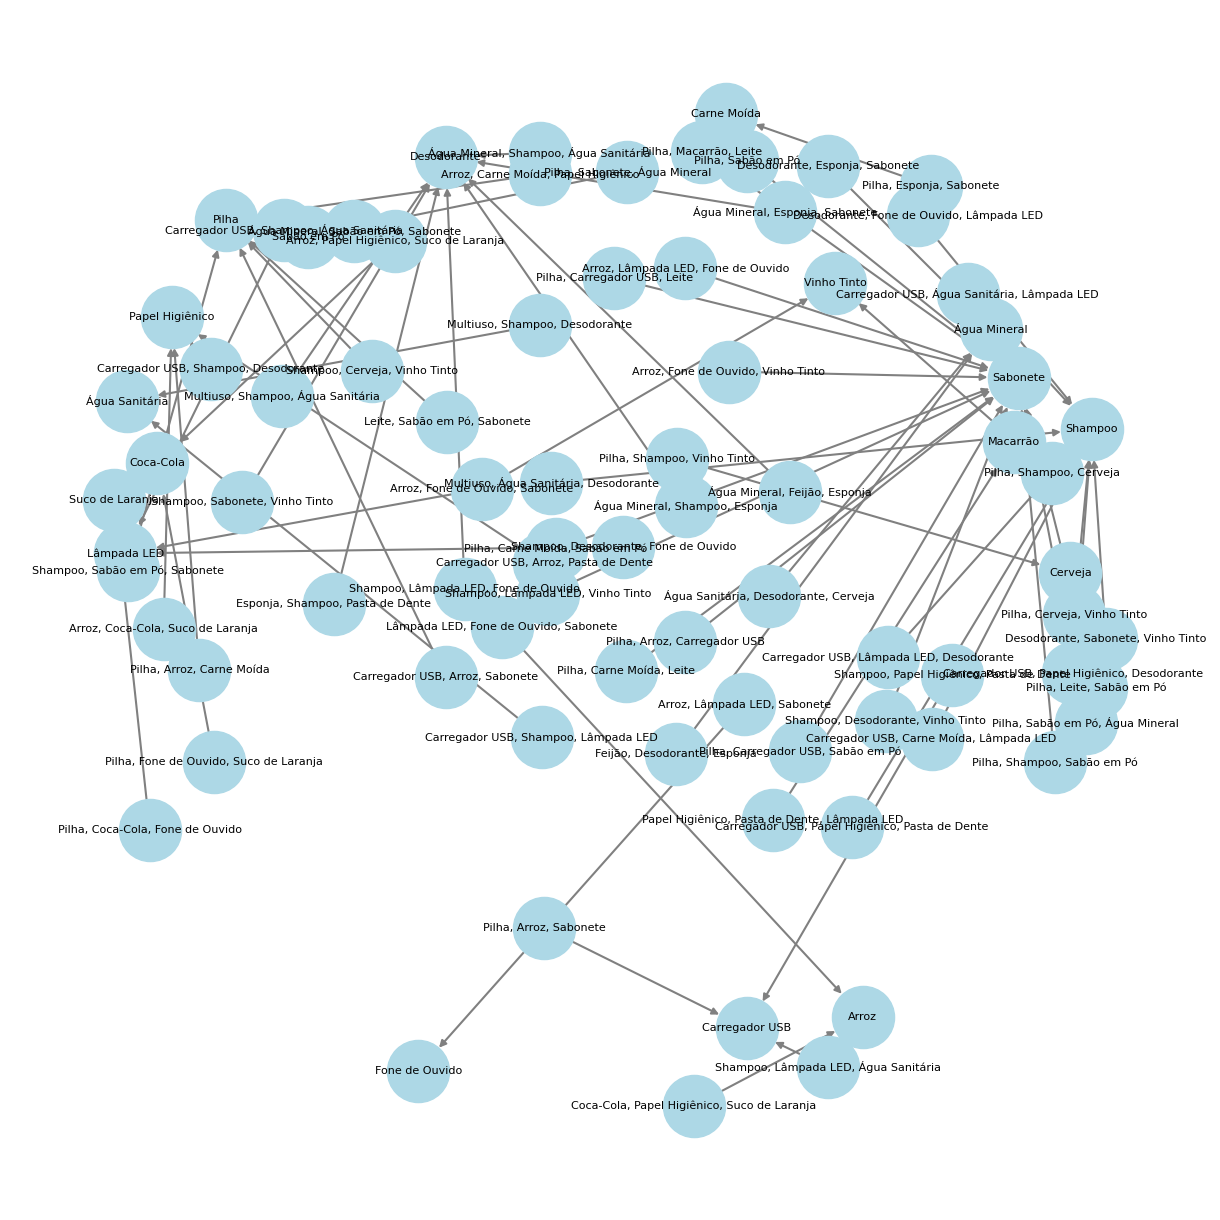

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Criar grafo das regras
G = nx.DiGraph()
for i, row in rules_filtered.iterrows():
    G.add_edge(', '.join(row['antecedents']), ', '.join(row['consequents']), weight=row['confidence'])

# Ajustar o layout do grafo
pos = nx.spring_layout(G, k=0.5, seed=42)  # Ajustar o valor de k para controlar o espaçamento entre nós

# Personalizar o desenho do grafo
plt.figure(figsize=(12, 12))  # Aumentar o tamanho da figura para melhorar a visibilidade
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=2000,        # Aumentar o tamanho dos nós
    node_color="lightblue",
    font_size=8,           # Reduzir a fonte para evitar sobreposição
    font_color="black",    # Garantir contraste no texto
    edge_color="gray",
    arrowsize=10,          # Ajustar o tamanho das setas
    width=1.5              # Espessura das arestas
)

# Adicionar título e ajustar margens
# plt.title("Regras de Associação", fontsize=16)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-18-0cd7a864e1d8>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rules_filtered['antecedents'] = rules_filtered['antecedents'] .apply(clean_frozenset)
<ipython-input-18-0cd7a864e1d8>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

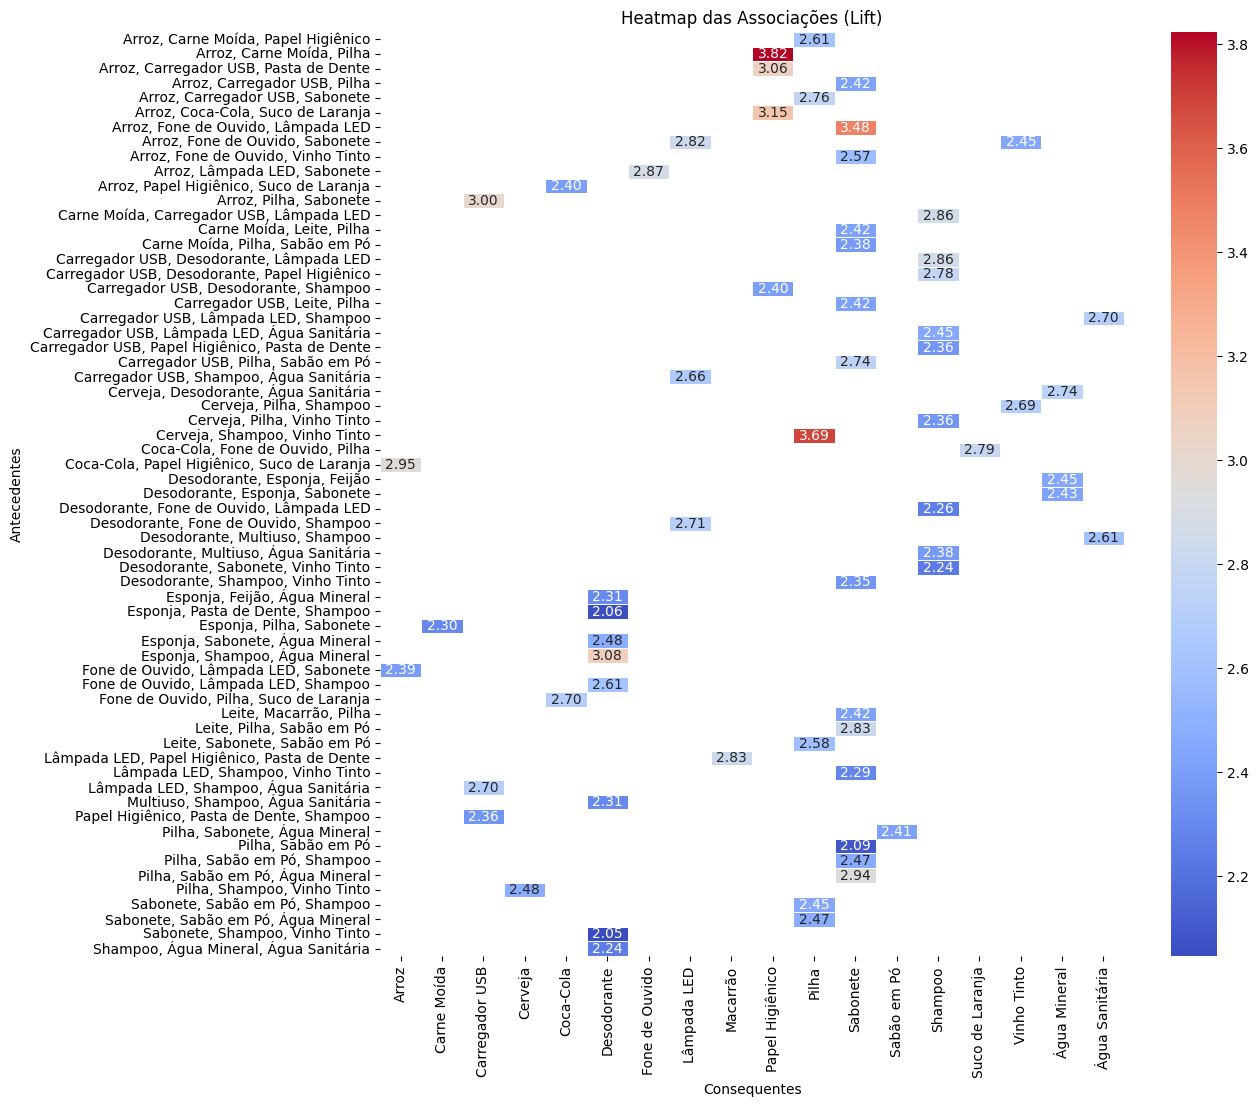

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Função para limpar os nomes removendo 'frozenset({})' e deixando formatado
def clean_frozenset(fset):
    return ", ".join(sorted(fset)).replace("'", "")

# Aplicando a limpeza nos nomes
rules_filtered['antecedents'] = rules_filtered['antecedents'] .apply(clean_frozenset)
rules_filtered['consequents'] = rules_filtered['consequents'].apply(clean_frozenset)

# Criar uma matriz de calor para o lift entre antecedents e consequents
heatmap_data = rules_filtered.pivot(index='antecedents', columns='consequents', values='lift')

# Configuração do tamanho da figura
plt.figure(figsize=(12, 12))

# Criar o heatmap com seaborn
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Configuração dos rótulos
plt.title("Heatmap das Associações (Lift)")
plt.xlabel("Consequentes")
plt.ylabel("Antecedentes")

# Exibir o gráfico
plt.show()


In [ ]:
# Ordenar primeiro por lift, depois por confiança e depois por suporte (todos em ordem decrescente)
rules_sorted = rules_filtered.sort_values(by=['lift', 'confidence', 'support'], ascending=[False, False, False])

# Pegar as 5 primeiras regras após a ordenação
top_5_rules = rules_sorted.head(5)

# Exibir o resultado
print("\nTop 5 regras ordenadas por lift, confiança e suporte:")
print(top_5_rules)



Top 5 regras ordenadas por lift, confiança e suporte:
                           antecedents      consequents  antecedent support  \
1            Arroz, Carne Moída, Pilha  Papel Higiênico               0.012   
47       Cerveja, Shampoo, Vinho Tinto            Pilha               0.014   
13  Arroz, Fone de Ouvido, Lâmpada LED         Sabonete               0.013   
10   Arroz, Coca-Cola, Suco de Laranja  Papel Higiênico               0.016   
55      Esponja, Shampoo, Água Mineral      Desodorante               0.014   

    consequent support  support  confidence      lift  representativity  \
1                0.218    0.010    0.833333  3.822630               1.0   
47               0.213    0.011    0.785714  3.688799               1.0   
13               0.243    0.011    0.846154  3.482115               1.0   
10               0.218    0.011    0.687500  3.153670               1.0   
55               0.255    0.011    0.785714  3.081232               1.0   

    leverage  convi

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-78-ba581d36cbe4>:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


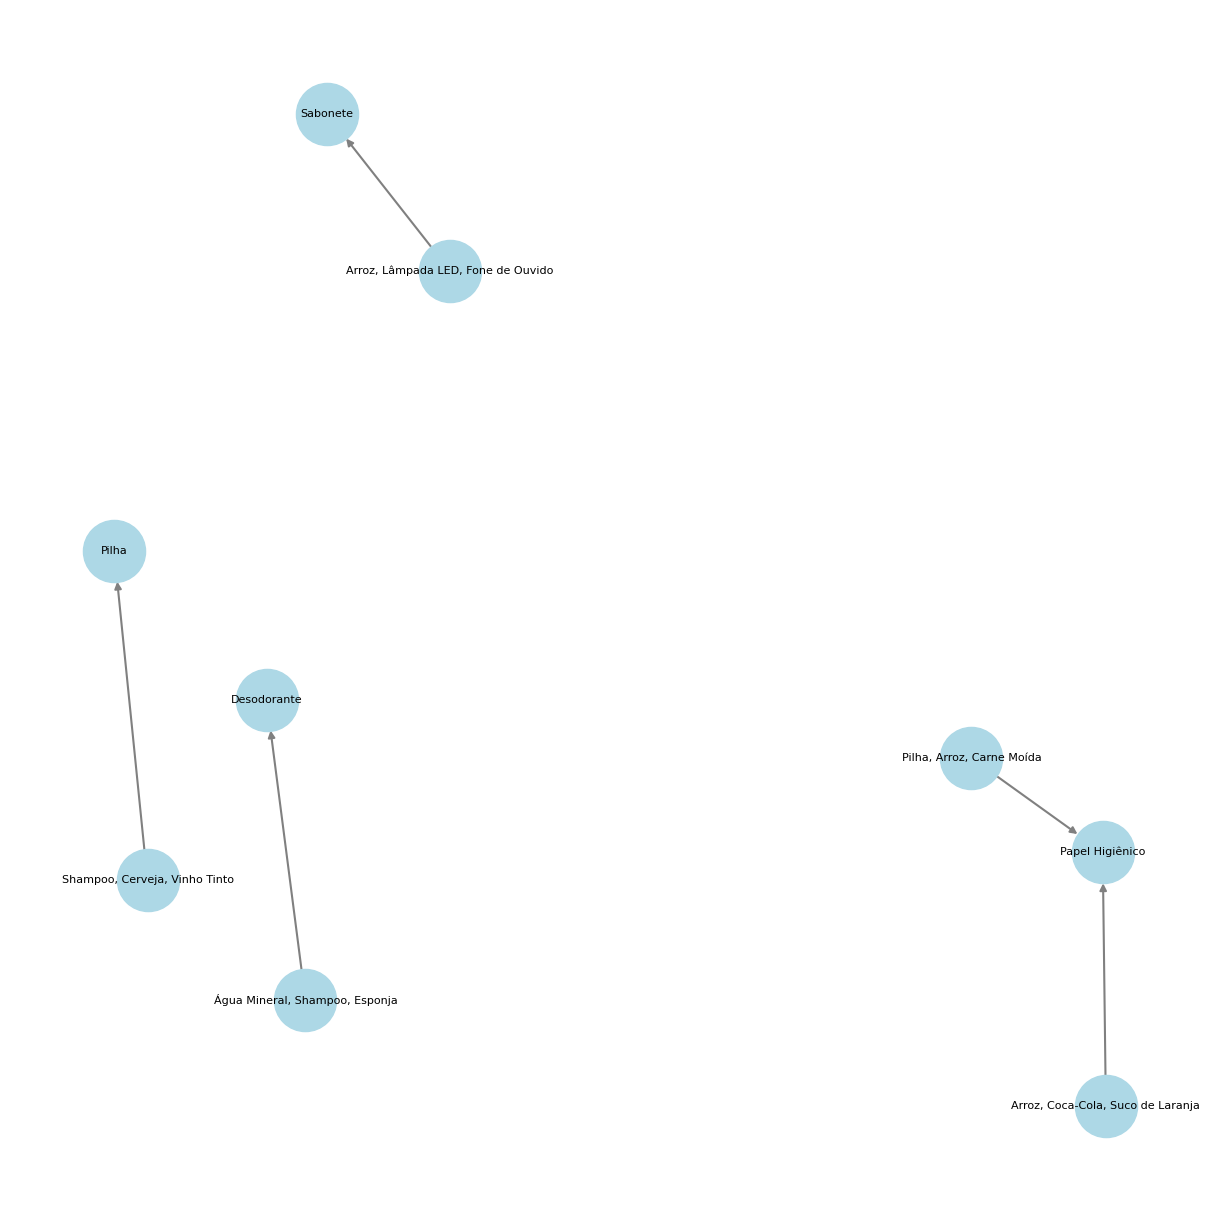

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Criar grafo das regras
G = nx.DiGraph()
for i, row in top_5_rules.iterrows():
    G.add_edge(', '.join(row['antecedents']), ', '.join(row['consequents']), weight=row['confidence'])

# Ajustar o layout do grafo
pos = nx.spring_layout(G, k=0.5, seed=42)  # Ajustar o valor de k para controlar o espaçamento entre nós

# Personalizar o desenho do grafo
plt.figure(figsize=(12, 12))  # Aumentar o tamanho da figura para melhorar a visibilidade
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=2000,        # Aumentar o tamanho dos nós
    node_color="lightblue",
    font_size=8,           # Reduzir a fonte para evitar sobreposição
    font_color="black",    # Garantir contraste no texto
    edge_color="gray",
    arrowsize=10,          # Ajustar o tamanho das setas
    width=1.5              # Espessura das arestas
)

# Adicionar título e ajustar margens
# plt.title("Regras de Associação", fontsize=16)
plt.tight_layout()
plt.show()
